In [1]:
#!/usr/bin/env python3
import random
import numpy as np
import pandas as pd
from pathlib import Path

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from torchvision import transforms
from torchvision.models import vgg16, VGG16_Weights
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tqdm import tqdm
import matplotlib.pyplot as plt

# ──────────────────────────────────────────────────────────────────────────────
# 1) Configuration & reproducibility
# ──────────────────────────────────────────────────────────────────────────────
STEGO_CSV    = Path("csv/stego_final.csv")
IMAGES_DIR   = Path("Images")
BATCH_SIZE   = 32
EPOCHS       = 25
LR           = 1e-3
WEIGHT_DECAY = 1e-4
LABEL_SMOOTH = 0.1
RANDOM_SEED  = 42

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

DEVICE = "cuda:1" if torch.cuda.is_available() else "cpu"

# ──────────────────────────────────────────────────────────────────────────────
# 2) Build & split DataFrame (3 classes: none, lsb, iwt)
# ──────────────────────────────────────────────────────────────────────────────
df = pd.read_csv(STEGO_CSV)
df_stego = df[df.method.isin(["lsb","iwt"])].copy()
df_stego["label"]    = df_stego["method"]
df_stego["img_path"] = df_stego["stego_path"]

n_stego    = len(df_stego)
all_images = list(IMAGES_DIR.glob("*"))
used_names = set(Path(p).name for p in df_stego["img_path"])
candidates = [str(p) for p in all_images if p.name not in used_names]
df_none = pd.DataFrame({
    "label":    ["none"] * n_stego,
    "img_path": random.sample(candidates, n_stego)
})

df3 = pd.concat([df_stego[["label","img_path"]], df_none], ignore_index=True)
df3 = df3.sample(frac=1, random_state=RANDOM_SEED).reset_index(drop=True)

df_train, df_test = train_test_split(
    df3, test_size=0.30, stratify=df3["label"], random_state=RANDOM_SEED
)
df_train, df_val  = train_test_split(
    df_train, test_size=0.20, stratify=df_train["label"], random_state=RANDOM_SEED
)

# ──────────────────────────────────────────────────────────────────────────────
# 3) Dataset & DataLoaders
# ──────────────────────────────────────────────────────────────────────────────
label_map = {"none": 0, "lsb": 1, "iwt": 2}

train_tf = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])
val_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406], [0.229,0.224,0.225]),
])

class Stego3Dataset(Dataset):
    def __init__(self, df, tf):
        self.df = df.reset_index(drop=True)
        self.tf = tf
    def __len__(self):
        return len(self.df)
    def __getitem__(self, idx):
        row   = self.df.iloc[idx]
        img   = Image.open(row.img_path).convert("RGB")
        img   = self.tf(img)
        label = label_map[row.label]
        return img, label

train_loader = DataLoader(
    Stego3Dataset(df_train, train_tf),
    batch_size=BATCH_SIZE, shuffle=True,
    num_workers=4, pin_memory=True
)
val_loader = DataLoader(
    Stego3Dataset(df_val,   val_tf),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True
)
test_loader = DataLoader(
    Stego3Dataset(df_test,  val_tf),
    batch_size=BATCH_SIZE, shuffle=False,
    num_workers=4, pin_memory=True
)

# ──────────────────────────────────────────────────────────────────────────────
# 4) Model: VGG-16 → 3-way head
# ──────────────────────────────────────────────────────────────────────────────
model = vgg16(weights=VGG16_Weights.IMAGENET1K_V1)
in_f = model.classifier[6].in_features
model.classifier[6] = nn.Linear(in_f, 3)
model = model.to(DEVICE)

# ──────────────────────────────────────────────────────────────────────────────
# 5) Loss, optimizer, TensorBoard (fixed LR)
# ──────────────────────────────────────────────────────────────────────────────
counts = df3.label.value_counts().to_dict()
total  = len(df3)
# simple inverse-frequency weights
weights = [ total/(3*counts[c]) for c in ["none","lsb","iwt"] ]
class_weights = torch.tensor(weights, device=DEVICE)

criterion = nn.CrossEntropyLoss(
    weight=class_weights,
    label_smoothing=LABEL_SMOOTH
)
optimizer = Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# no scheduler — LR remains fixed at LR throughout training

writer       = SummaryWriter("runs/stego_vgg3_fixedlr")
train_losses = []; val_losses = []
train_accs   = []; val_accs   = []




2025-05-01 22:55:29.101598: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-01 22:55:29.111193: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746140129.123474    7828 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746140129.127216    7828 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-01 22:55:29.139924: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
# ──────────────────────────────────────────────────────────────────────────────
# 6) Training & validation loops
# ──────────────────────────────────────────────────────────────────────────────
def train_epoch():
    model.train()
    loss_sum = correct = total = 0
    for imgs, lbls in tqdm(train_loader, desc="Train", leave=False):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        optimizer.zero_grad()
        out  = model(imgs)
        loss = criterion(out, lbls)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item() * lbls.size(0)
        preds    = out.argmax(dim=1)
        correct  += (preds==lbls).sum().item()
        total    += lbls.size(0)
    return loss_sum/total, correct/total

@torch.no_grad()
def validate():
    model.eval()
    loss_sum = correct = total = 0
    for imgs, lbls in tqdm(val_loader, desc="Val  ", leave=False):
        imgs, lbls = imgs.to(DEVICE), lbls.to(DEVICE)
        out  = model(imgs)
        loss = criterion(out, lbls)

        loss_sum += loss.item() * lbls.size(0)
        preds    = out.argmax(dim=1)
        correct  += (preds==lbls).sum().item()
        total    += lbls.size(0)
    return loss_sum/total, correct/total

best_val_acc = 0.0
for epoch in range(1, EPOCHS+1):
    tr_loss, tr_acc   = train_epoch()
    val_loss, val_acc = validate()

    train_losses.append(tr_loss);  val_losses.append(val_loss)
    train_accs.append(tr_acc);     val_accs.append(val_acc)

    writer.add_scalar("Loss/train", tr_loss, epoch)
    writer.add_scalar("Loss/val",   val_loss, epoch)
    writer.add_scalar("Acc/train",  tr_acc,   epoch)
    writer.add_scalar("Acc/val",    val_acc,   epoch)

    print(f"Epoch {epoch}/{EPOCHS}  "
          f"Train loss={tr_loss:.4f}, acc={tr_acc:.4f}  "
          f" Val loss={val_loss:.4f}, acc={val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_vgg3_fixedlr.pth")
        print(" → new best!")

writer.close()



Epoch 1/25  Train loss=1.2705, acc=0.3244   Val loss=1.1661, acc=0.2637
 → new best!


Epoch 2/25  Train loss=1.1273, acc=0.3051   Val loss=1.1150, acc=0.2373


Epoch 3/25  Train loss=1.1179, acc=0.3112   Val loss=1.1127, acc=0.2373


Epoch 4/25  Train loss=1.1206, acc=0.2985   Val loss=1.1109, acc=0.2411


Epoch 5/25  Train loss=1.1480, acc=0.3065   Val loss=1.1272, acc=0.2373


Epoch 6/25  Train loss=1.2107, acc=0.2848   Val loss=1.1139, acc=0.2373


Epoch 7/25  Train loss=1.1154, acc=0.2674   Val loss=1.1117, acc=0.2637


Epoch 8/25  Train loss=1.1293, acc=0.3395   Val loss=1.0946, acc=0.2637


Epoch 9/25  Train loss=1.1731, acc=0.2759   Val loss=1.1112, acc=0.2637


Epoch 10/25  Train loss=1.1139, acc=0.2952   Val loss=1.1118, acc=0.2637


Epoch 11/25  Train loss=1.1145, acc=0.2618   Val loss=1.1122, acc=0.2637


Epoch 12/25  Train loss=1.1504, acc=0.2881   Val loss=1.1304, acc=0.2373


Epoch 13/25  Train loss=1.1296, acc=0.3107   Val loss=1.1133, acc=0.4991
 → new best!


Epoch 14/25  Train loss=1.1138, acc=0.2891   Val loss=1.1111, acc=0.2637


Epoch 15/25  Train loss=1.1136, acc=0.2651   Val loss=1.1117, acc=0.2373


Epoch 16/25  Train loss=1.1129, acc=0.3136   Val loss=1.1112, acc=0.2637


Epoch 17/25  Train loss=1.1152, acc=0.2580   Val loss=1.1112, acc=0.2637


Epoch 18/25  Train loss=1.1118, acc=0.2740   Val loss=1.1112, acc=0.2373


Epoch 19/25  Train loss=5.2405, acc=0.3244   Val loss=1.1115, acc=0.2373


Epoch 20/25  Train loss=1.1507, acc=0.2575   Val loss=1.1113, acc=0.2373


Epoch 21/25  Train loss=1.1139, acc=0.2472   Val loss=1.1114, acc=0.2373


Epoch 22/25  Train loss=1.1135, acc=0.3121   Val loss=1.1113, acc=0.2637


Epoch 23/25  Train loss=1.1129, acc=0.2702   Val loss=1.1116, acc=0.2637


Epoch 24/25  Train loss=1.1121, acc=0.2905   Val loss=1.1118, acc=0.2373


Epoch 25/25  Train loss=1.1133, acc=0.2599   Val loss=1.1113, acc=0.2637


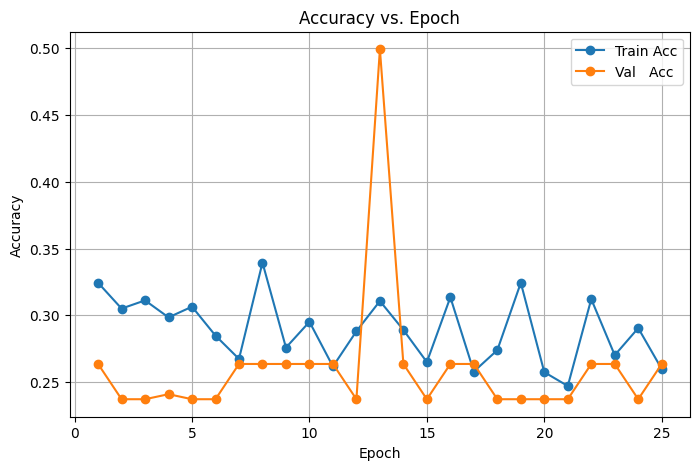

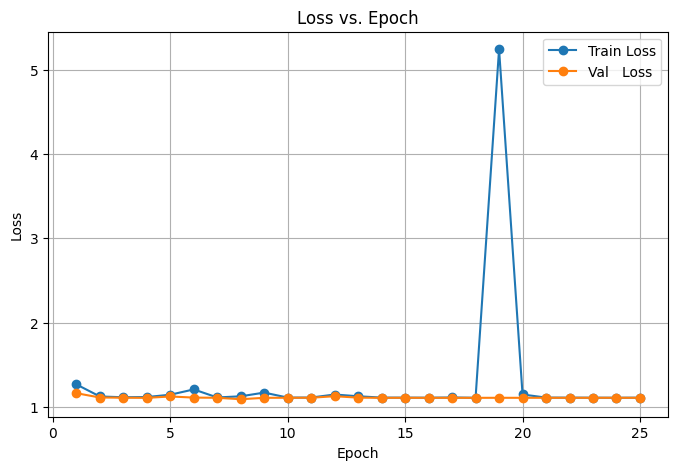

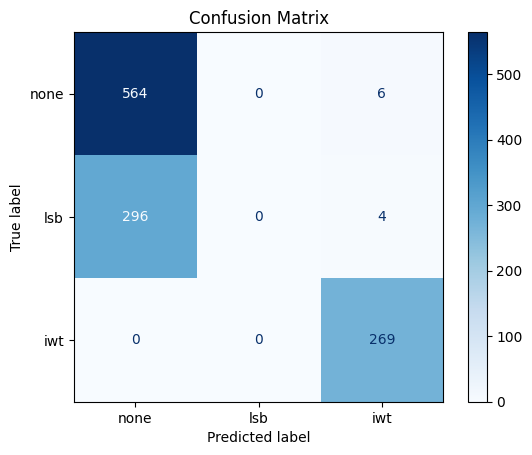

              precision    recall  f1-score   support

        none       0.66      0.99      0.79       570
         lsb       0.00      0.00      0.00       300
         iwt       0.96      1.00      0.98       269

    accuracy                           0.73      1139
   macro avg       0.54      0.66      0.59      1139
weighted avg       0.56      0.73      0.63      1139



/home/nitinjha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nitinjha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nitinjha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [3]:
# ──────────────────────────────────────────────────────────────────────────────
# 7) Plot Loss & Accuracy vs. Epoch
# ──────────────────────────────────────────────────────────────────────────────
epochs = range(1, EPOCHS+1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_accs, marker='o', label='Train Acc')
plt.plot(epochs, val_accs,   marker='o', label='Val   Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch'); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses,   marker='o', label='Val   Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss vs. Epoch'); plt.legend(); plt.grid(True); plt.show()

# ──────────────────────────────────────────────────────────────────────────────
# 8) Test-set evaluation
# ──────────────────────────────────────────────────────────────────────────────
model.load_state_dict(torch.load("best_vgg3.pth"))
model.eval()

all_lbls, all_preds = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(DEVICE)
        out  = model(imgs)
        preds = out.argmax(dim=1).cpu().numpy()
        all_lbls.extend(lbls.numpy())
        all_preds.extend(preds)

# confusion matrix & report
cm = confusion_matrix(all_lbls, all_preds)
ConfusionMatrixDisplay(cm, display_labels=["none","lsb","iwt"])\
    .plot(cmap="Blues")
plt.title("Confusion Matrix"); plt.show()

print(classification_report(
    all_lbls, all_preds,
    target_names=["none","lsb","iwt"]
))

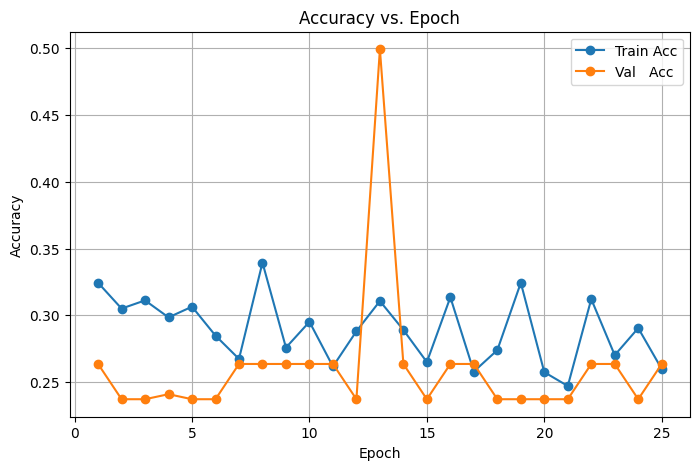

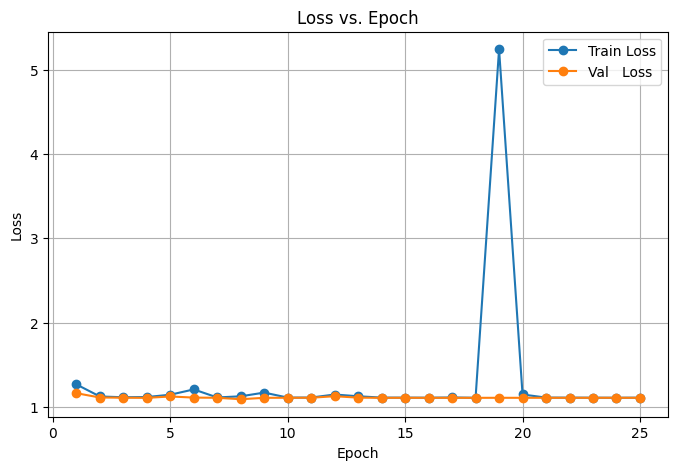

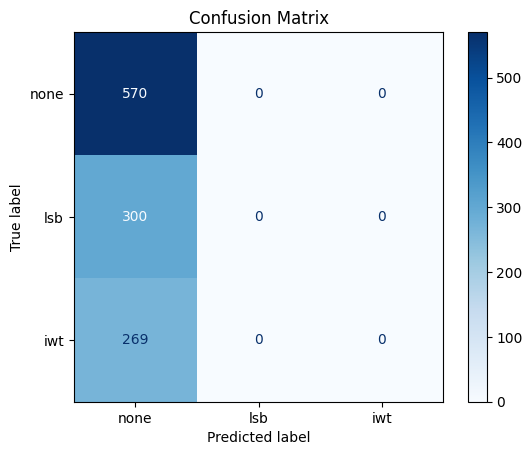

              precision    recall  f1-score   support

        none       0.50      1.00      0.67       570
         lsb       0.00      0.00      0.00       300
         iwt       0.00      0.00      0.00       269

    accuracy                           0.50      1139
   macro avg       0.17      0.33      0.22      1139
weighted avg       0.25      0.50      0.33      1139



/home/nitinjha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nitinjha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/nitinjha/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [4]:
# ──────────────────────────────────────────────────────────────────────────────
# 7) Plot Loss & Accuracy vs. Epoch
# ──────────────────────────────────────────────────────────────────────────────
epochs = range(1, EPOCHS+1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_accs, marker='o', label='Train Acc')
plt.plot(epochs, val_accs,   marker='o', label='Val   Acc')
plt.xlabel('Epoch'); plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch'); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, marker='o', label='Train Loss')
plt.plot(epochs, val_losses,   marker='o', label='Val   Loss')
plt.xlabel('Epoch'); plt.ylabel('Loss')
plt.title('Loss vs. Epoch'); plt.legend(); plt.grid(True); plt.show()

# ──────────────────────────────────────────────────────────────────────────────
# 8) Test-set evaluation
# ──────────────────────────────────────────────────────────────────────────────
model.load_state_dict(torch.load("best_vgg3_fixedlr.pth"))
model.eval()

all_lbls, all_preds = [], []
with torch.no_grad():
    for imgs, lbls in test_loader:
        imgs = imgs.to(DEVICE)
        out  = model(imgs)
        preds= out.argmax(dim=1).cpu().numpy()
        all_lbls.extend(lbls.numpy())
        all_preds.extend(preds)

cm = confusion_matrix(all_lbls, all_preds)
ConfusionMatrixDisplay(cm, display_labels=["none","lsb","iwt"])\
    .plot(cmap="Blues")
plt.title("Confusion Matrix"); plt.show()

print(classification_report(
    all_lbls, all_preds,
    target_names=["none","lsb","iwt"]
))